## Binary Classification: Titanic Dataset
https://www.kaggle.com/c/titanic

** Dataset Information: **

- 891+418 passenger information aboard the Titanic

** Attribute Information: (9 features and 1 class)**


Variable	Definition	     Key
1. survival	Survival	     0 = No, 1 = Yes
2. pclass	Ticket class	 1 = 1st, 2 = 2nd, 3 = 3rd
3. sex	    Sex	
4. Age	    Age in years	
5. sibsp	# of siblings / spouses aboard the Titanic	
6. parch	# of parents / children aboard the Titanic	
7. ticket	Ticket number	
8. fare	    Passenger fare	
9. cabin	Cabin number	
10. embarked Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

** Objective of this project **

- predict whether a passenger survived the sinking of the Titanic or not

# 1. Data

In [17]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold,cross_val_score,GridSearchCV,learning_curve
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier,BaggingClassifier,                              
                              AdaBoostClassifier,GradientBoostingClassifier,
                              ExtraTreesClassifier,VotingClassifier)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

%matplotlib inline  
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.3f}'.format

In [18]:
# Load Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]

In [19]:
# Inspect Data
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C


In [8]:
train.info()
print('==='*20)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000,418.000,332.000,418.000,418.000,417.000
mean,"1,100.500",2.266,30.273,0.447,0.392,35.627
std,120.810,0.842,14.181,0.897,0.981,55.908
min,892.000,1.000,0.170,0.000,0.000,0.000
25%,996.250,1.000,21.000,0.000,0.000,7.896
50%,"1,100.500",3.000,27.000,0.000,0.000,14.454
75%,"1,204.750",3.000,39.000,1.000,0.000,31.500
max,"1,309.000",3.000,76.000,8.000,9.000,512.329


# 2. EDA (train only)

### Numerical Features

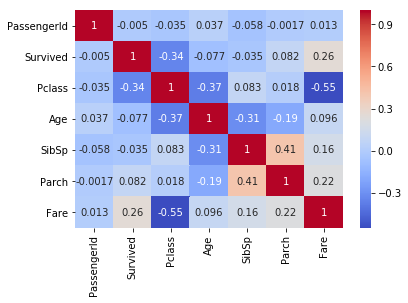

In [192]:
# correlations
g = sns.heatmap(train.corr(), annot = True, cmap='coolwarm')

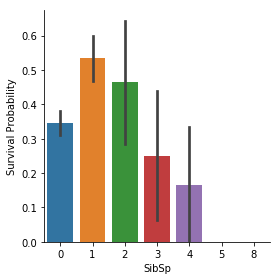

In [193]:
# SibSp
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar",size=4)
g = g.set_ylabels("Survival Probability")

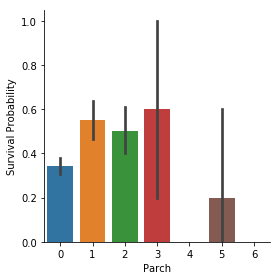

In [194]:
# Parch
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar",size=4)
g = g.set_ylabels("Survival Probability")

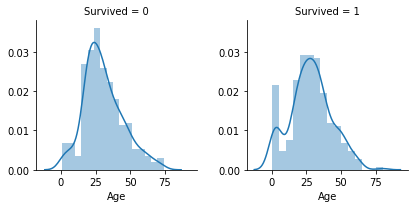

In [178]:
# Age
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

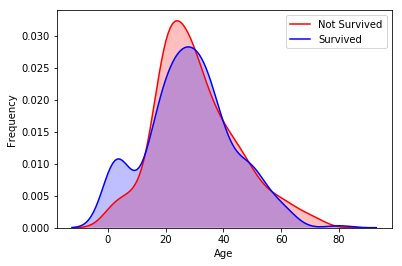

In [179]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

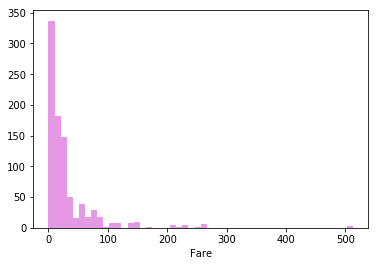

In [181]:
# Fare
g = sns.distplot(train["Fare"], color="m", kde=False)

### Categorical Features

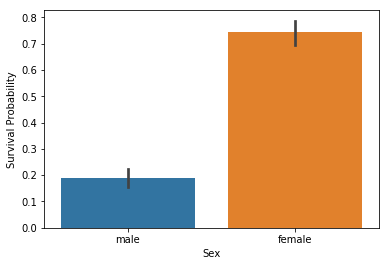

In [216]:
# Sex 
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

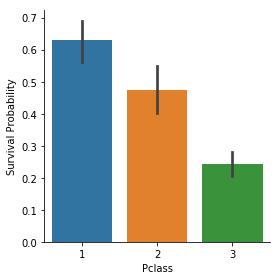

In [215]:
# Pclass
g = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar")
g = g.set_ylabels("Survival Probability")

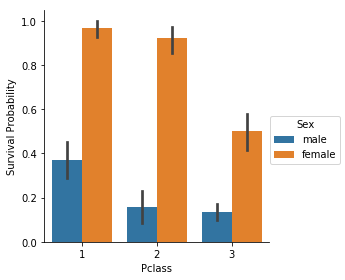

In [214]:
# Sex vs Pclass
g = sns.factorplot(x="Pclass",y="Survived",hue="Sex",data=train,kind="bar")
g = g.set_ylabels("Survival Probability")

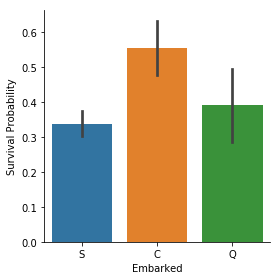

In [213]:
# Emabark
g = sns.factorplot(x="Embarked",y="Survived",data=train,kind="bar")
g = g.set_ylabels("Survival Probability")

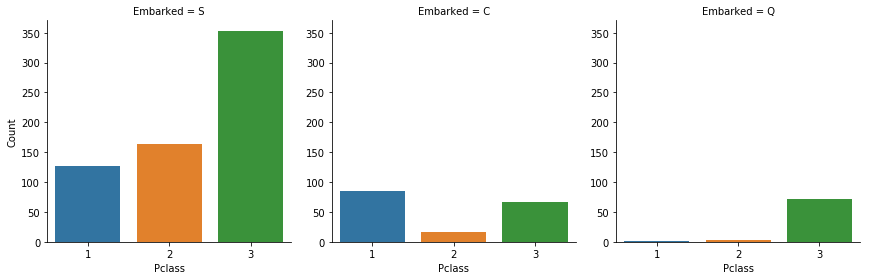

In [217]:
# Pclass vs Embarked
g = sns.factorplot("Pclass",col="Embarked",data=train,kind="count")
g = g.set_ylabels("Count")

### Combined

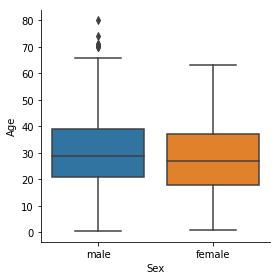

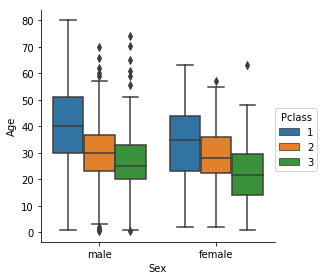

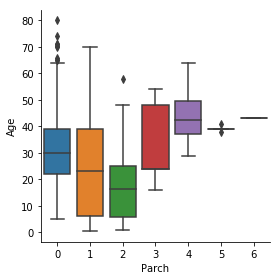

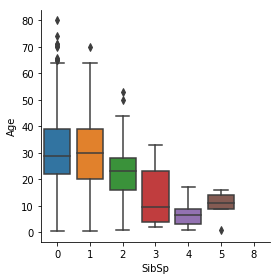

In [201]:
# Age vs Sex,Pclass,Parch,SibSp
g = sns.factorplot(y="Age", x="Sex", data=train, kind="box")
g = sns.factorplot(y="Age", x="Sex", hue="Pclass", data=train, kind="box")
g = sns.factorplot(y="Age", x="Parch", data=train, kind="box")
g = sns.factorplot(y="Age", x="SibSp", data=train, kind="box")

# 3. Data preprocessing (train+test)

In [20]:
# Join train & test datasets
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
dataset = dataset.fillna(np.nan)

### Filling Missing Data

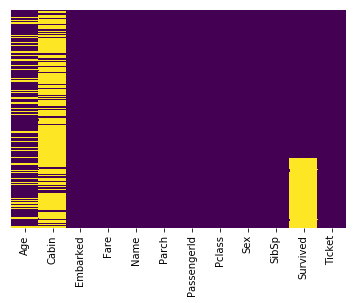

In [318]:
# Missing data
g = sns.heatmap(dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [21]:
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [22]:
# Embarked: most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [23]:
# Fare: median
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Pclass
1   39.000
2   29.000
3   24.000
Name: Age, dtype: float64

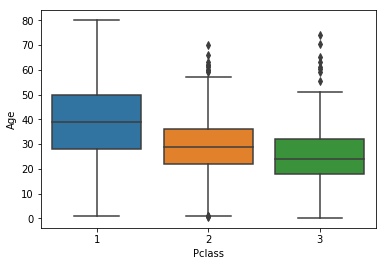

In [24]:
# Age: median in Pclass
g = sns.boxplot(x='Pclass',y='Age',data=dataset)
dataset.groupby(by='Pclass').median()['Age']

In [25]:
def impute_age(cols):   
    if pd.isnull(cols[0]):
        return np.round(dataset.groupby(by='Pclass').median()['Age'][cols[1]])
    else:
        return cols[0]

dataset['Age'] = dataset[['Age','Pclass']].apply(impute_age,axis=1)

### Feature Engineering

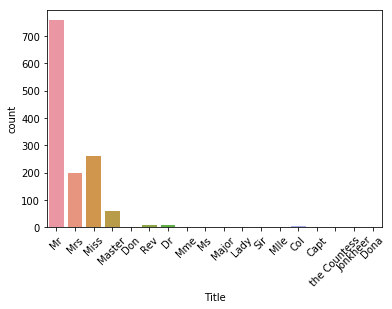

In [26]:
# Title from Name
dataset["Title"] = pd.Series(
    [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]])
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

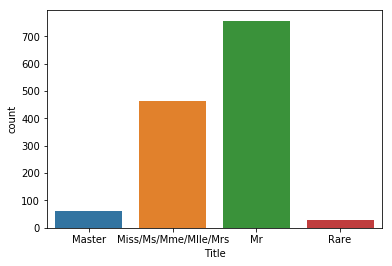

In [27]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

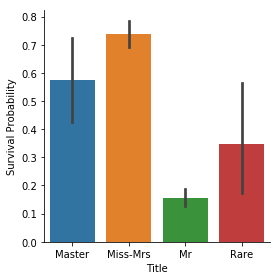

In [28]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("Survival Probability")

In [29]:
# drop columns
dataset.drop(['PassengerId','Name','Cabin','Ticket'],axis=1,inplace=True)

In [30]:
dataset.isnull().sum()

Age           0
Embarked      0
Fare          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    418
Title         0
dtype: int64

### Encode Categocial to Dummy Variables

In [31]:
dataset = pd.get_dummies(dataset,drop_first=True)
dataset.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,Title,Embarked_Q,Embarked_S,Sex_male
0,22.000,7.250,0,3,1,0.000,2,0,1,1
1,38.000,71.283,0,1,1,1.000,1,0,0,0
2,26.000,7.925,0,3,0,1.000,1,0,1,0
3,35.000,53.100,0,1,1,1.000,1,0,1,0
4,35.000,8.050,0,3,0,0.000,2,0,1,1


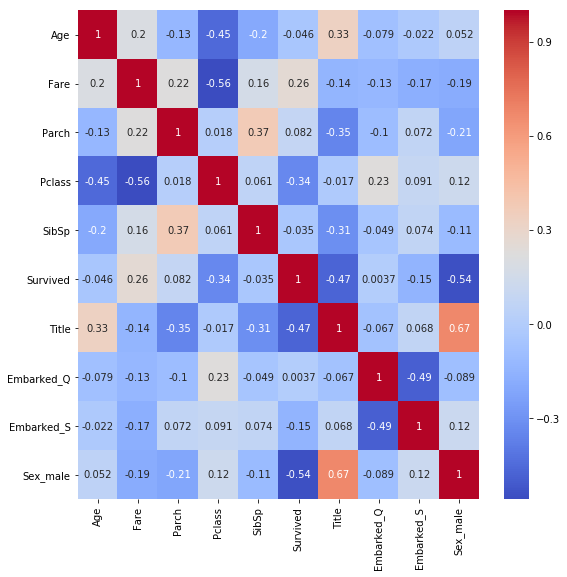

In [32]:
# correlations
plt.figure(figsize=(9,9))
sns.heatmap(dataset.corr(), annot = True, cmap='coolwarm')

### Split Features and Label

In [33]:
train = dataset[:train_len]
test = dataset[train_len:]

X_train = train.drop("Survived", axis = 1)
y_train = train["Survived"].astype(int)
X_test = test.drop("Survived", axis = 1)

### Scale Features

In [34]:
scaler = StandardScaler()
X_train[['Age','Fare']] = scaler.fit_transform(X_train[['Age','Fare']])
X_test[['Age','Fare']] = scaler.transform(X_test[['Age','Fare']])
X_train.head()

,Age,Fare,Parch,Pclass,SibSp,Title,Embarked_Q,Embarked_S,Sex_male
0,-0.537,-0.502,0,3,1,2,0,1,1
1,0.668,0.787,0,1,1,1,0,0,0
2,-0.236,-0.489,0,3,0,1,0,1,0
3,0.442,0.421,0,1,1,1,0,1,0
4,0.442,-0.486,0,3,0,2,0,1,1


# 4. Modeling

### Baseline Models

In [35]:
seed = 123 #random seed for reproducibility
np.random.seed(seed)
n_jobs = 4

n_splits = 10 #10 folds
scoring='accuracy'
kfold = StratifiedKFold(n_splits=n_splits, random_state=seed)

In [36]:
# Define baseline_models
def baseline_models():
    models = []
    #linear
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    #non-linear
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('SVM', SVC(probability=True)))
    #ensemble
    models.append(('RF', RandomForestClassifier(random_state=seed)))
    models.append(('Bag', BaggingClassifier(random_state=seed)))
    models.append(('Ext',ExtraTreesClassifier(random_state=seed)))
    models.append(('Ada', AdaBoostClassifier(random_state=seed)))
    models.append(('GB', GradientBoostingClassifier(random_state=seed)))
    models.append(('XGB', XGBClassifier(random_state=seed)))
    #neural network              
    models.append(('MLP', MLPClassifier(random_state=seed)))    
    #Voting Ensemble
    estimators = []
    estimators.append(('LR', LogisticRegression()))
    estimators.append(('LDA', LinearDiscriminantAnalysis()))
    estimators.append(('KNN', KNeighborsClassifier()))
    estimators.append(('NB', GaussianNB()))
    estimators.append(('DT', DecisionTreeClassifier()))
    estimators.append(('SVM', SVC(probability=True)))
    estimators.append(('RF', RandomForestClassifier(random_state=seed)))
    estimators.append(('Bag', BaggingClassifier(random_state=seed)))
    estimators.append(('Ext',ExtraTreesClassifier(random_state=seed)))
    estimators.append(('Ada', AdaBoostClassifier(random_state=seed)))
    estimators.append(('GB', GradientBoostingClassifier(random_state=seed)))
    estimators.append(('XGB', XGBClassifier(random_state=seed)))
    estimators.append(('MLP', MLPClassifier(random_state=seed)))        
    models.append(('Vot', VotingClassifier(estimators,voting='soft')))
    return models

In [37]:
# cross validation
def cv_models(models=baseline_models(), X=X_train, y=y_train, n_splits=n_splits, scoring=scoring):
    
    #cv
    names = []
    results = []    
    for name,model in models:
        results.append(cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=n_jobs)*100)                            
        names.append(name)
        
    #sort results by mean acc.
    cv_results = pd.DataFrame(data=results, index=names)
    cv_results['acc_mean(%)'] = cv_results.iloc[:,:n_splits].mean(axis=1)
    cv_results['acc_std(%)'] = cv_results.iloc[:,:n_splits].std(axis=1)
    cv_results.sort_values(by=['acc_mean(%)','acc_std(%)'],ascending=False, inplace=True)
    print(cv_results[['acc_mean(%)','acc_std(%)']])
    
    # visualize results
    plt.figure(figsize=(10,5))
    ax = sns.boxplot(data=cv_results.iloc[:,:n_splits].T)
    ax.set_xticklabels(cv_results.index)
    ax.set_title('Model Comparison (ordered by mean accuracy)')
    plt.ylabel('Accuracy(%)') 
    
    return cv_results

     acc_mean(%)  acc_std(%)
GB        83.394       4.004
Vot       83.392       4.478
SVM       82.941       2.787
XGB       82.274       4.095
LDA       82.271       3.280
RF        82.052       5.200
Ada       81.936       2.339
Bag       81.832       5.354
LR        81.705       3.228
NB        81.152       2.838
KNN       80.589       3.091
MLP       79.461       3.175
Ext       79.358       3.576
DT        77.450       6.018


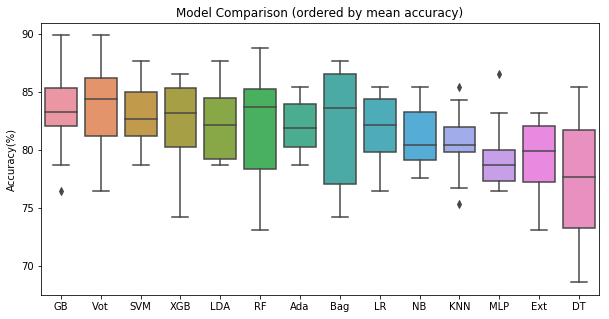

In [272]:
cv_results = cv_models(models=baseline_models())

### Parameter Tuning
Top 6 algorithms: GB, SVM, XGB, LDA, RF, Ada

In [38]:
def get_best_estimator(model,param_grid):
    # grid search
    grid_search = GridSearchCV(model, param_grid=param_grid,cv=kfold, verbose=1, scoring=scoring, n_jobs=n_jobs)
    grid_result = grid_search.fit(X_train,y_train)
    
    # results
    means = grid_result.cv_results_['mean_test_score']*100
    stds = grid_result.cv_results_['std_test_score']*100
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%.3f (%.3f)%% with: %r" % (mean, stdev, param))

    # best
    print("\nBest accuracy of train set: %.1f%% using %s" % (grid_result.best_score_*100, grid_result.best_params_))
    
    return grid_result.best_estimator_    

In [39]:
def plot_learning_curve(estimator, title, X=X_train, y=y_train, ylim=None, cv=kfold,
                        n_jobs=n_jobs, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Samples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    8.1s finished


84.175 (4.855)% with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
85.073 (4.635)% with: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
83.277 (3.380)% with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
82.941 (3.611)% with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}

Best accuracy of train set: 85.1% using {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}


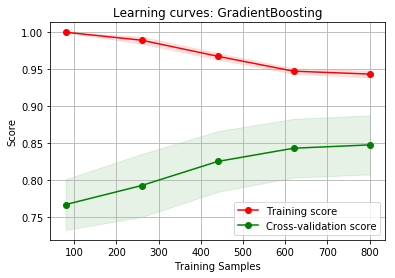

In [40]:
# GradientBoosting
model = GradientBoostingClassifier(random_state=seed)
param_grid = {'learning_rate': [0.05, 0.1], #[0.001,0.01]
              'n_estimators': [100, 200], #[50,300]
              'max_depth': [4], #[3,4,5,6,8,10]
              'subsample': [0.9] #,[1, 0.9, 0.8]
             }
GB_best_estimator = get_best_estimator(model,param_grid)
g = plot_learning_curve(GB_best_estimator,'Learning curves: GradientBoosting')

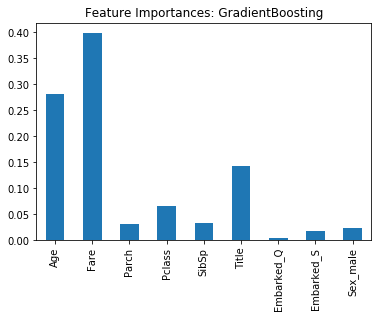

In [41]:
g = pd.DataFrame(
    data=GB_best_estimator.feature_importances_,
    index=train.drop('Survived',axis=1).columns)\
    .plot(kind='bar',legend=False,
          title='Feature Importances: GradientBoosting')

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   15.0s finished


82.716 (4.346)% with: {'C': 100, 'gamma': 0.05}
83.165 (4.228)% with: {'C': 100, 'gamma': 0.04}
82.604 (4.148)% with: {'C': 100, 'gamma': 0.03}
83.389 (3.399)% with: {'C': 100, 'gamma': 0.01}
83.277 (3.562)% with: {'C': 10, 'gamma': 0.05}
83.614 (3.407)% with: {'C': 10, 'gamma': 0.04}
83.614 (3.143)% with: {'C': 10, 'gamma': 0.03}
82.941 (2.879)% with: {'C': 10, 'gamma': 0.01}
82.941 (2.821)% with: {'C': 1, 'gamma': 0.05}
82.828 (2.920)% with: {'C': 1, 'gamma': 0.04}
82.941 (2.916)% with: {'C': 1, 'gamma': 0.03}
81.257 (3.450)% with: {'C': 1, 'gamma': 0.01}
82.043 (3.205)% with: {'C': 0.1, 'gamma': 0.05}
81.818 (3.427)% with: {'C': 0.1, 'gamma': 0.04}
81.930 (3.000)% with: {'C': 0.1, 'gamma': 0.03}
68.687 (4.149)% with: {'C': 0.1, 'gamma': 0.01}

Best accuracy of train set: 83.6% using {'C': 10, 'gamma': 0.04}


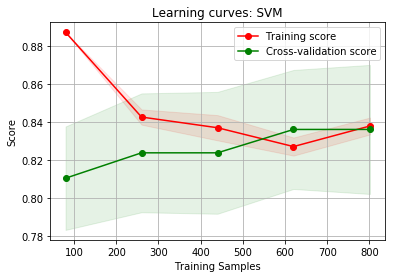

In [42]:
# SVM
model = SVC(kernel='rbf',probability=True)
param_grid = {'C': [100, 10, 1, 0.1],
              'gamma': [ 0.05, 0.04, 0.03, 0.01]
             }
SVM_best_estimator = get_best_estimator(model,param_grid)
g = plot_learning_curve(SVM_best_estimator,'Learning curves: SVM')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 113 out of 120 | elapsed:    5.6s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    5.8s finished


82.492 (4.064)% with: {'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 10, 'subsample': 0.9}
83.165 (4.001)% with: {'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 20, 'subsample': 0.9}
83.838 (3.504)% with: {'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'subsample': 0.9}
81.594 (3.031)% with: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 10, 'subsample': 0.9}
83.165 (4.480)% with: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 20, 'subsample': 0.9}
82.604 (3.700)% with: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'subsample': 0.9}
82.492 (2.978)% with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 10, 'subsample': 0.9}
82.828 (2.935)% with: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 20, 'subsample': 0.9}
83.614 (3.653)% with: {'

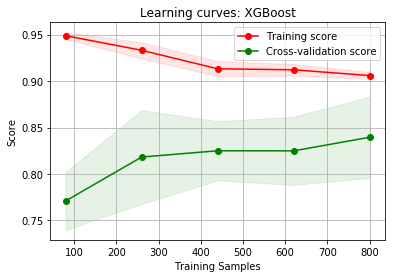

In [43]:
# XGBoost
model = XGBClassifier(random_state=seed)
param_grid = {'n_estimators': [10, 20, 50],#,100,200]
              'max_depth': [3],#[3,4,5],
              'learning_rate': [0.5,0.3,0.1,0.01],
              'min_child_weight': [2],#[1,2]
              'subsample': [0.9] #[0.8,0.9,1]
             }
XGB_best_estimator = get_best_estimator(model,param_grid)
g = plot_learning_curve(XGB_best_estimator,'Learning curves: XGBoost')

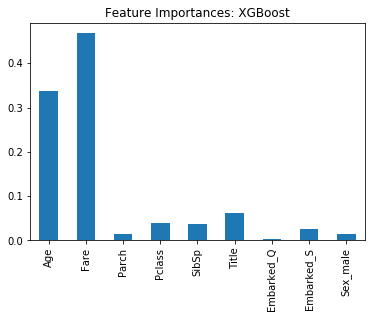

In [44]:
g = pd.DataFrame(
    data=XGB_best_estimator.feature_importances_,
    index=train.drop('Survived',axis=1).columns)\
    .plot(kind='bar',legend=False,
          title='Feature Importances: XGBoost')

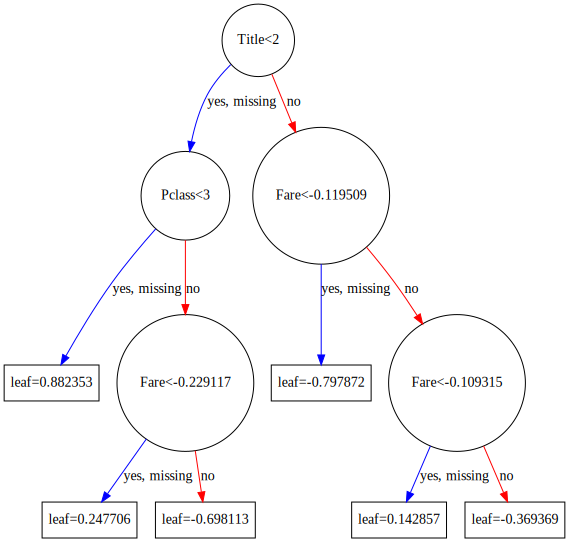

In [45]:
# plot tree
xgb.to_graphviz(XGB_best_estimator)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    5.3s finished


82.267 (3.109)% with: {'solver': 'svd'}
82.155 (2.928)% with: {'shrinkage': 0, 'solver': 'lsqr'}
80.696 (3.649)% with: {'shrinkage': 0, 'solver': 'eigen'}
82.716 (3.568)% with: {'shrinkage': 0.2, 'solver': 'lsqr'}
81.594 (3.262)% with: {'shrinkage': 0.2, 'solver': 'eigen'}
82.155 (3.229)% with: {'shrinkage': 0.4, 'solver': 'lsqr'}
79.686 (3.820)% with: {'shrinkage': 0.4, 'solver': 'eigen'}
82.043 (3.514)% with: {'shrinkage': 0.6, 'solver': 'lsqr'}
79.125 (4.178)% with: {'shrinkage': 0.6, 'solver': 'eigen'}
79.686 (4.986)% with: {'shrinkage': 0.8, 'solver': 'lsqr'}
78.451 (4.416)% with: {'shrinkage': 0.8, 'solver': 'eigen'}
76.207 (5.536)% with: {'shrinkage': 1, 'solver': 'lsqr'}
76.543 (5.318)% with: {'shrinkage': 1, 'solver': 'eigen'}

Best accuracy of train set: 82.7% using {'shrinkage': 0.2, 'solver': 'lsqr'}


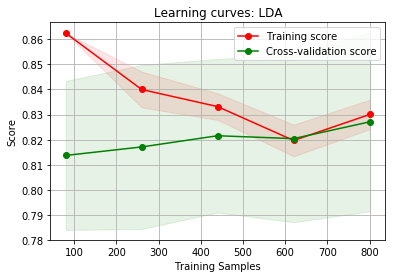

In [46]:
# LDA
model = LinearDiscriminantAnalysis()
param_grid = [{'solver': ['svd']},
              {'solver': ['lsqr','eigen'],
              'shrinkage': [0,0.2,0.4,0.6,0.8,1]
              }]
LDA_best_estimator = get_best_estimator(model,param_grid)
g = plot_learning_curve(LDA_best_estimator,'Learning curves: LDA')

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   33.3s finished


82.941 (5.122)% with: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 50}
83.838 (4.712)% with: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 100}
83.614 (4.583)% with: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 200}
84.400 (4.953)% with: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 50}
84.063 (5.136)% with: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 100}
84.063 (5.223)% with: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 200}
82.828 (5.214)% with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}
82.828 (4.754)% with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
83.277 (4.336)% with: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
84.063 (5.133)% with: {'criterion': 'gini', 'max_depth': 10, 'mi

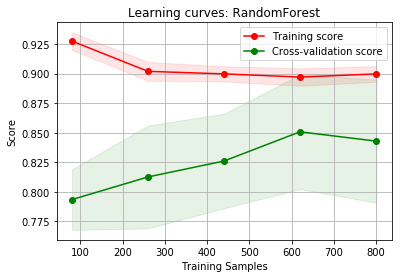

In [47]:
# RandomForest
model = RandomForestClassifier(random_state=seed)
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [9,10],
              'criterion': ['gini','entropy'],
              'min_samples_leaf': [1,2]
              }
RF_best_estimator = get_best_estimator(model,param_grid)
g = plot_learning_curve(RF_best_estimator,'Learning curves: RandomForest')

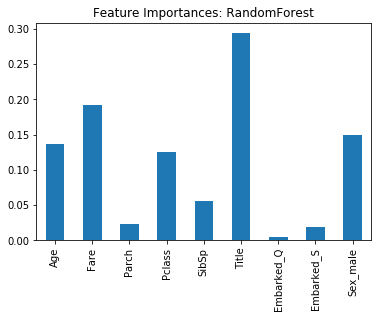

In [48]:
g = pd.DataFrame(
    data=RF_best_estimator.feature_importances_,
    index=train.drop('Survived',axis=1).columns)\
    .plot(kind='bar',legend=False,
          title='Feature Importances: RandomForest')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   21.6s finished


79.012 (3.415)% with: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 100}
78.900 (3.362)% with: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 200}
81.818 (3.171)% with: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
82.043 (3.263)% with: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 200}
82.828 (2.734)% with: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100}
82.492 (2.433)% with: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}
79.012 (3.415)% with: {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 100}
78.900 (3.278)% with: {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 200}
81.818 (2.131)% with: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
81.369 (2.906)% with: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 200}
82.155 (2.445)% with: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 100}
81.706 (2.690)% wi

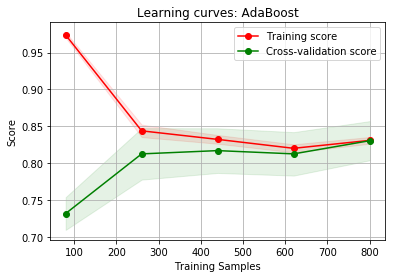

In [49]:
# AdaBoost
model = AdaBoostClassifier(random_state=seed)
param_grid = {'n_estimators': [100, 200],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate': [0.01, 0.1, 1.0] 
             }
Ada_best_estimator = get_best_estimator(model,param_grid)
g = plot_learning_curve(Ada_best_estimator,'Learning curves: AdaBoost')

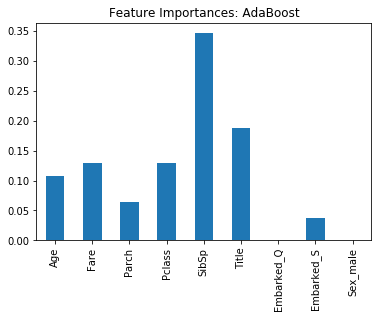

In [50]:
g = pd.DataFrame(
    data=Ada_best_estimator.feature_importances_,
    index=train.drop('Survived',axis=1).columns)\
    .plot(kind='bar',legend=False,
          title='Feature Importances: AdaBoost')

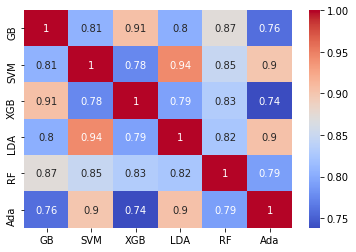

In [51]:
# Individual Model Predictions
predictions = pd.concat(
    [pd.Series(GB_best_estimator.predict(X_test), name='GB'),
     pd.Series(SVM_best_estimator.predict(X_test), name='SVM'),
     pd.Series(XGB_best_estimator.predict(X_test), name='XGB'),
     pd.Series(LDA_best_estimator.predict(X_test), name='LDA'),
     pd.Series(RF_best_estimator.predict(X_test), name='RF'),
     pd.Series(Ada_best_estimator.predict(X_test), name='Ada')
    ], axis=1)

g= sns.heatmap(predictions.corr(),annot=True,cmap='coolwarm')  

# 5. Final Model: Voting Ensemble

Accuracy of final model: 84.7 (4.0)%

             precision    recall  f1-score   support

          0       0.88      0.95      0.91       549
          1       0.90      0.80      0.85       342

avg / total       0.89      0.89      0.89       891



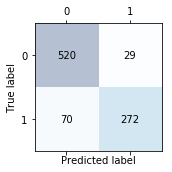

In [52]:
final_model = VotingClassifier(
    estimators=[('GB', GB_best_estimator),
                ('SVM', SVM_best_estimator),
                ('XGB', XGB_best_estimator),
                ('LDA', LDA_best_estimator),
                ('RF', RF_best_estimator),
                ('Ada', Ada_best_estimator)],
    voting='soft', 
    n_jobs=n_jobs)

cv = cross_val_score(final_model, X_train, y_train, cv=kfold, scoring=scoring, 
                     n_jobs=n_jobs)*100
print('Accuracy of final model: {:0.1f} ({:0.1f})%'.format(cv.mean(), cv.std()))
print()

final_model = final_model.fit(X_train, y_train)     

#classification report
print(classification_report(y_train, final_model.predict(X_train)))
#confusion matrix
confmat = confusion_matrix(y_train, final_model.predict(X_train))
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# 6. Predictions

In [53]:
# Make predictions
y_pred = final_model.predict(X_test)

# Prepare submission results
submission_results = pd.concat([IDtest,
                                pd.Series(y_pred, name="Survived")]
                               , axis=1)
submission_results.to_csv('titanic_submission.csv',index=False)